# LISA Solar Wind Displacement Noise Calculator

Calculator to estimate displacement noise caused by solar plasma effects in the Laser Interferometer Space Antenna (LISA) Gravitational Wave detector. Solar electron density measurements from NASA's _Wind_ spacecraft are read in and processed to produce power specrtal densities of electron density fluctuations. A simple transfer function is then applied to estimate the fluctuations in electron column density along the LISA arms.  Finally, a comparison is made with the results from Smetana, 2020 (https://arxiv.org/pdf/2008.11105.pdf). The plots produced by this calculator are used in the accompanying paper.

Authors: N. Luetzgendorf, I. Thorpe
Date: 2021.04.26


## Setup

### Import libraries
Note: This notebook uses pycdf from spacepy. Spacepy can be installed though PyPI (https://spacepy.github.io/install.html) in order for pycdf to work you also need to install the NASA CDF Library (https://cdf.gsfc.nasa.gov/html/sw_and_docs.html)

In [1]:
import os
import glob
import copy
from datetime import datetime, time
import numpy as np
import math
from spacepy import pycdf
from matplotlib import pyplot as plt
from matplotlib import gridspec
from astropy import units as u
from astropy import constants as c
from astropy.modeling import models, powerlaws, functional_models, custom_model, fitting
from scipy.signal import welch, medfilt, butter, filtfilt, savgol_filter
from chainconsumer import ChainConsumer


### Define LTPDA-like Spikecleaning function

In [2]:
def spikecleaning(data, kspike=3.3, fc=0.025, fs=1 , order=2, method='random'):
    """ Spike cleaning algorithm adopted from LTPDA
    
    From LTPDA:
    https://www.lisamission.org/ltpda/usermanual/funcbycat/html/ao_spikecleaning.html

    SPIKECLEANING detects spikes in the temperature data and
            replaces them by artificial values depending on the method
            chosen ('random', 'mean', 'previous', 'linear', 'spline').
            The first three methods consider extrapolation techniques
            linear and spline apply interpolations to the data.
 
            Spikes are defined as singular samples or groups of samples
            with an (absolute) value higher than kspike times the
            standard deviation of the high-pass filtered (IIR filter)
            input AO.x
    
    This does not have all the LTPDA functionalities. Methods spline and linear
    are not yet implemented. Also the ripple input parameter is not used because
    I think it is also not used inthe LTPDA routine at the end. 
    
    Parameters
    ----------
    data : list/array
        Input data to despike.
    kspike : float
        Multipication factor of sigma for data higher
        than this will be flagged as spikes.
        (Default: 3.3)
    fc : float 
        Critical frequency. Frequency cut-off of the IIR filter.
        (Default: 0.025)
    fs : float 
        Sampling frequency. (Default: 1)
    order : int
        Order of the IIR filter. (Default: 2)
    method : str
        The method used to replace the spike value. Random and 
        mean follow extrapolation methods. Choices are ['random', 'mean', 'previous'].
        (Default: 'random')
    
    Returns
    -------
    array/list
        Spike cleaned data. 
    
    
    """
    # Prepare ouput data
    data_out = copy.deepcopy(data)
    
    # Apply a high-pass filter to the data
    b, a = butter(order, fc, btype='high', fs=fs) # using the fs keyword is the same as using 2fc/fs as critical wl
    d_filt = filtfilt(b, a, data)
    
    # Calculate the standard deviation of the filtered data
    d_nfilt = d_filt[np.abs(d_filt) < kspike * np.std(d_filt)]
    d_std = np.std(d_nfilt)
    
    # Find the spikes
    find = np.where(np.abs(d_filt) > (kspike * d_std))
    
    # Replace the spikes depending on the method
    for ii in find[0]:
        if method == "random":
            data_out[ii] = data_out[ii-1] + np.random.rand(1) * d_std
        elif method == "mean":
            data_out[ii] = (data_out[ii-1] + data_out[ii-2])/2.
        elif method == "previous":
            data_out[ii] = data_out[ii-1]
    
    return data_out

## Processing Wind/SWE Data

The data is not part of this repository. To download it visit https://cdaweb.gsfc.nasa.gov/pub/data/wind/swe/swe_h0/ and pick the data for 1998 and 1997 and place it in the directory `data/cdf`


### Reading in the data files

In [3]:
data_dir = './data/cdf'
files = glob.glob('{:s}/*.cdf'.format(data_dir))
print('{} files found!'.format(len(files)))

642 files found!


#### Read all the events and select them by distance and min and max values in electron density (this takes a little bit)

In [4]:
ed = []
seconds = []
datelist = []
for file in files:
    cdf = pycdf.CDF(file)
    # Select the data that is suitably far away from Earth
    mean_sc_pos_x = np.mean(cdf['sc_position'][:,0])
    if mean_sc_pos_x <= 10:
        continue
    # Select the data where the electron density is positive
    min_el_density = np.min(cdf['el_density'][:])
    if min_el_density < 0:
        continue
    # Select the data where the electron density is not larger than 100
    max_el_density = np.max(cdf['el_density'][:])
    if max_el_density > 100:
        continue
    # Save the name
    date = str.split(file, '_')[3]
    datelist.append(date)
    # Calculate how many seconds since midnight have passed
    midnight = datetime.combine(cdf['Epoch'][0].date(), time(hour=0))
    seconds_tmp = np.array([(t - midnight).seconds for t in cdf['Epoch'][:]])
    # Find non monotonic entries
    find = [True] + [x<y for x, y in zip(seconds_tmp, seconds_tmp[1:])]
    # Append to the lists
    ed.append(cdf['el_density'][:][find])
    seconds.append(seconds_tmp[find])
print("{} files selected from {}".format(len(datelist), len(files)))

/Users/jthorpe/opt/anaconda3/envs/py38/lib/python3.8/site-packages/spacepy/pycdf/__init__.py:3957: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.degen = numpy.zeros(self.dims, dtype=numpy.bool)
/Users/jthorpe/opt/anaconda3/envs/py38/lib/python3.8/site-packages/spacepy/pycdf/__init__.py:3958: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.r

620 files selected from 642


### Computing the power spectral density

#### Resampling to an equally spaced grid every 5 s

In [5]:
fs = 0.2
sec = np.arange(0, 86400, 1./fs)
ed_samp = [np.interp(sec, x, y) for x,y in zip(seconds, ed)]

#### Apply spike cleaning to data

In [6]:
ed_filt = [spikecleaning(y, kspike=2, fs=fs, method='previous') for y in ed_samp]

#### Estimate power spectral density using the Welch method

In [7]:
sne = [welch(x, fs, window='blackmanharris', nperseg=3e3, noverlap=50, nfft=3e3) for x in ed_filt]

### Fit the electron density spectrum to a power law
Theoretical model predicts a power-law spectrum with an index of -5/3

In [8]:
# we will fit the log-log with a linear model so that we weight ly RMS of the error in the log
model = functional_models.Linear1D(intercept = 1, slope=-5/3)
fitter = fitting.LinearLSQFitter()
amplitudes = []
alphas = []
pfit = []
for snq in sne:
    xx = snq[0][1:]
    yy = snq[1][1:]
    # Fitting only frequencies between 1e-4 and 1e-2
    find = (1e-4 < xx) & (xx < 1e-2) 
    xx=np.log10(xx[find])
    yy=np.log10(yy[find])

    t = fitter(model, xx, yy)
    pfit.append(t)
    amplitudes.append(10**(t.intercept.value-3*t.slope.value))
    alphas.append(t.slope.value)

amplitudes = np.asarray(amplitudes)
alphas = np.asarray(alphas)

In [9]:
# organize data by fit amplitude and by time
dtlist = [datetime.strptime(t, '%Y%m%d') for t in datelist]
dtlist = np.array(dtlist)
# sort data by amplitude
inda = np.argsort(amplitudes)
dtlist_a = dtlist[inda]
amp_sort_a = amplitudes[inda]
alpha_sort_a = alphas[inda]
# Sort data by date
indt = np.argsort(dtlist_a)
dtlist_t = dtlist_a[indt]
amp_sort_t = amp_sort_a[indt]
alpha_sort_t = alpha_sort_a[indt]
print('Min amplitude: %s, %f \nMax date: %s, %f\nMedian amplitude: %s, %f \nMedian date: %s, %f\n' % (dtlist_a[0].strftime('%Y-%m-%d'), amp_sort_a[0],dtlist_a[-1].strftime('%Y-%m-%d'),amp_sort_a[-1],dtlist_a[int(len(amplitudes)/2)].strftime('%Y-%m-%d'),amp_sort_a[int(len(amplitudes)/2)],dtlist_t[int(len(amplitudes)/2)].strftime('%Y-%m-%d'),amp_sort_t[int(len(amplitudes)/2)]))

Min amplitude: 1998-04-27, 1.324765 
Max date: 1998-08-01, 8037.785295
Median amplitude: 1997-02-19, 55.891240 
Median date: 1997-12-05, 5.517008



### Plots of Wind/SWE data

#### Example Spectra

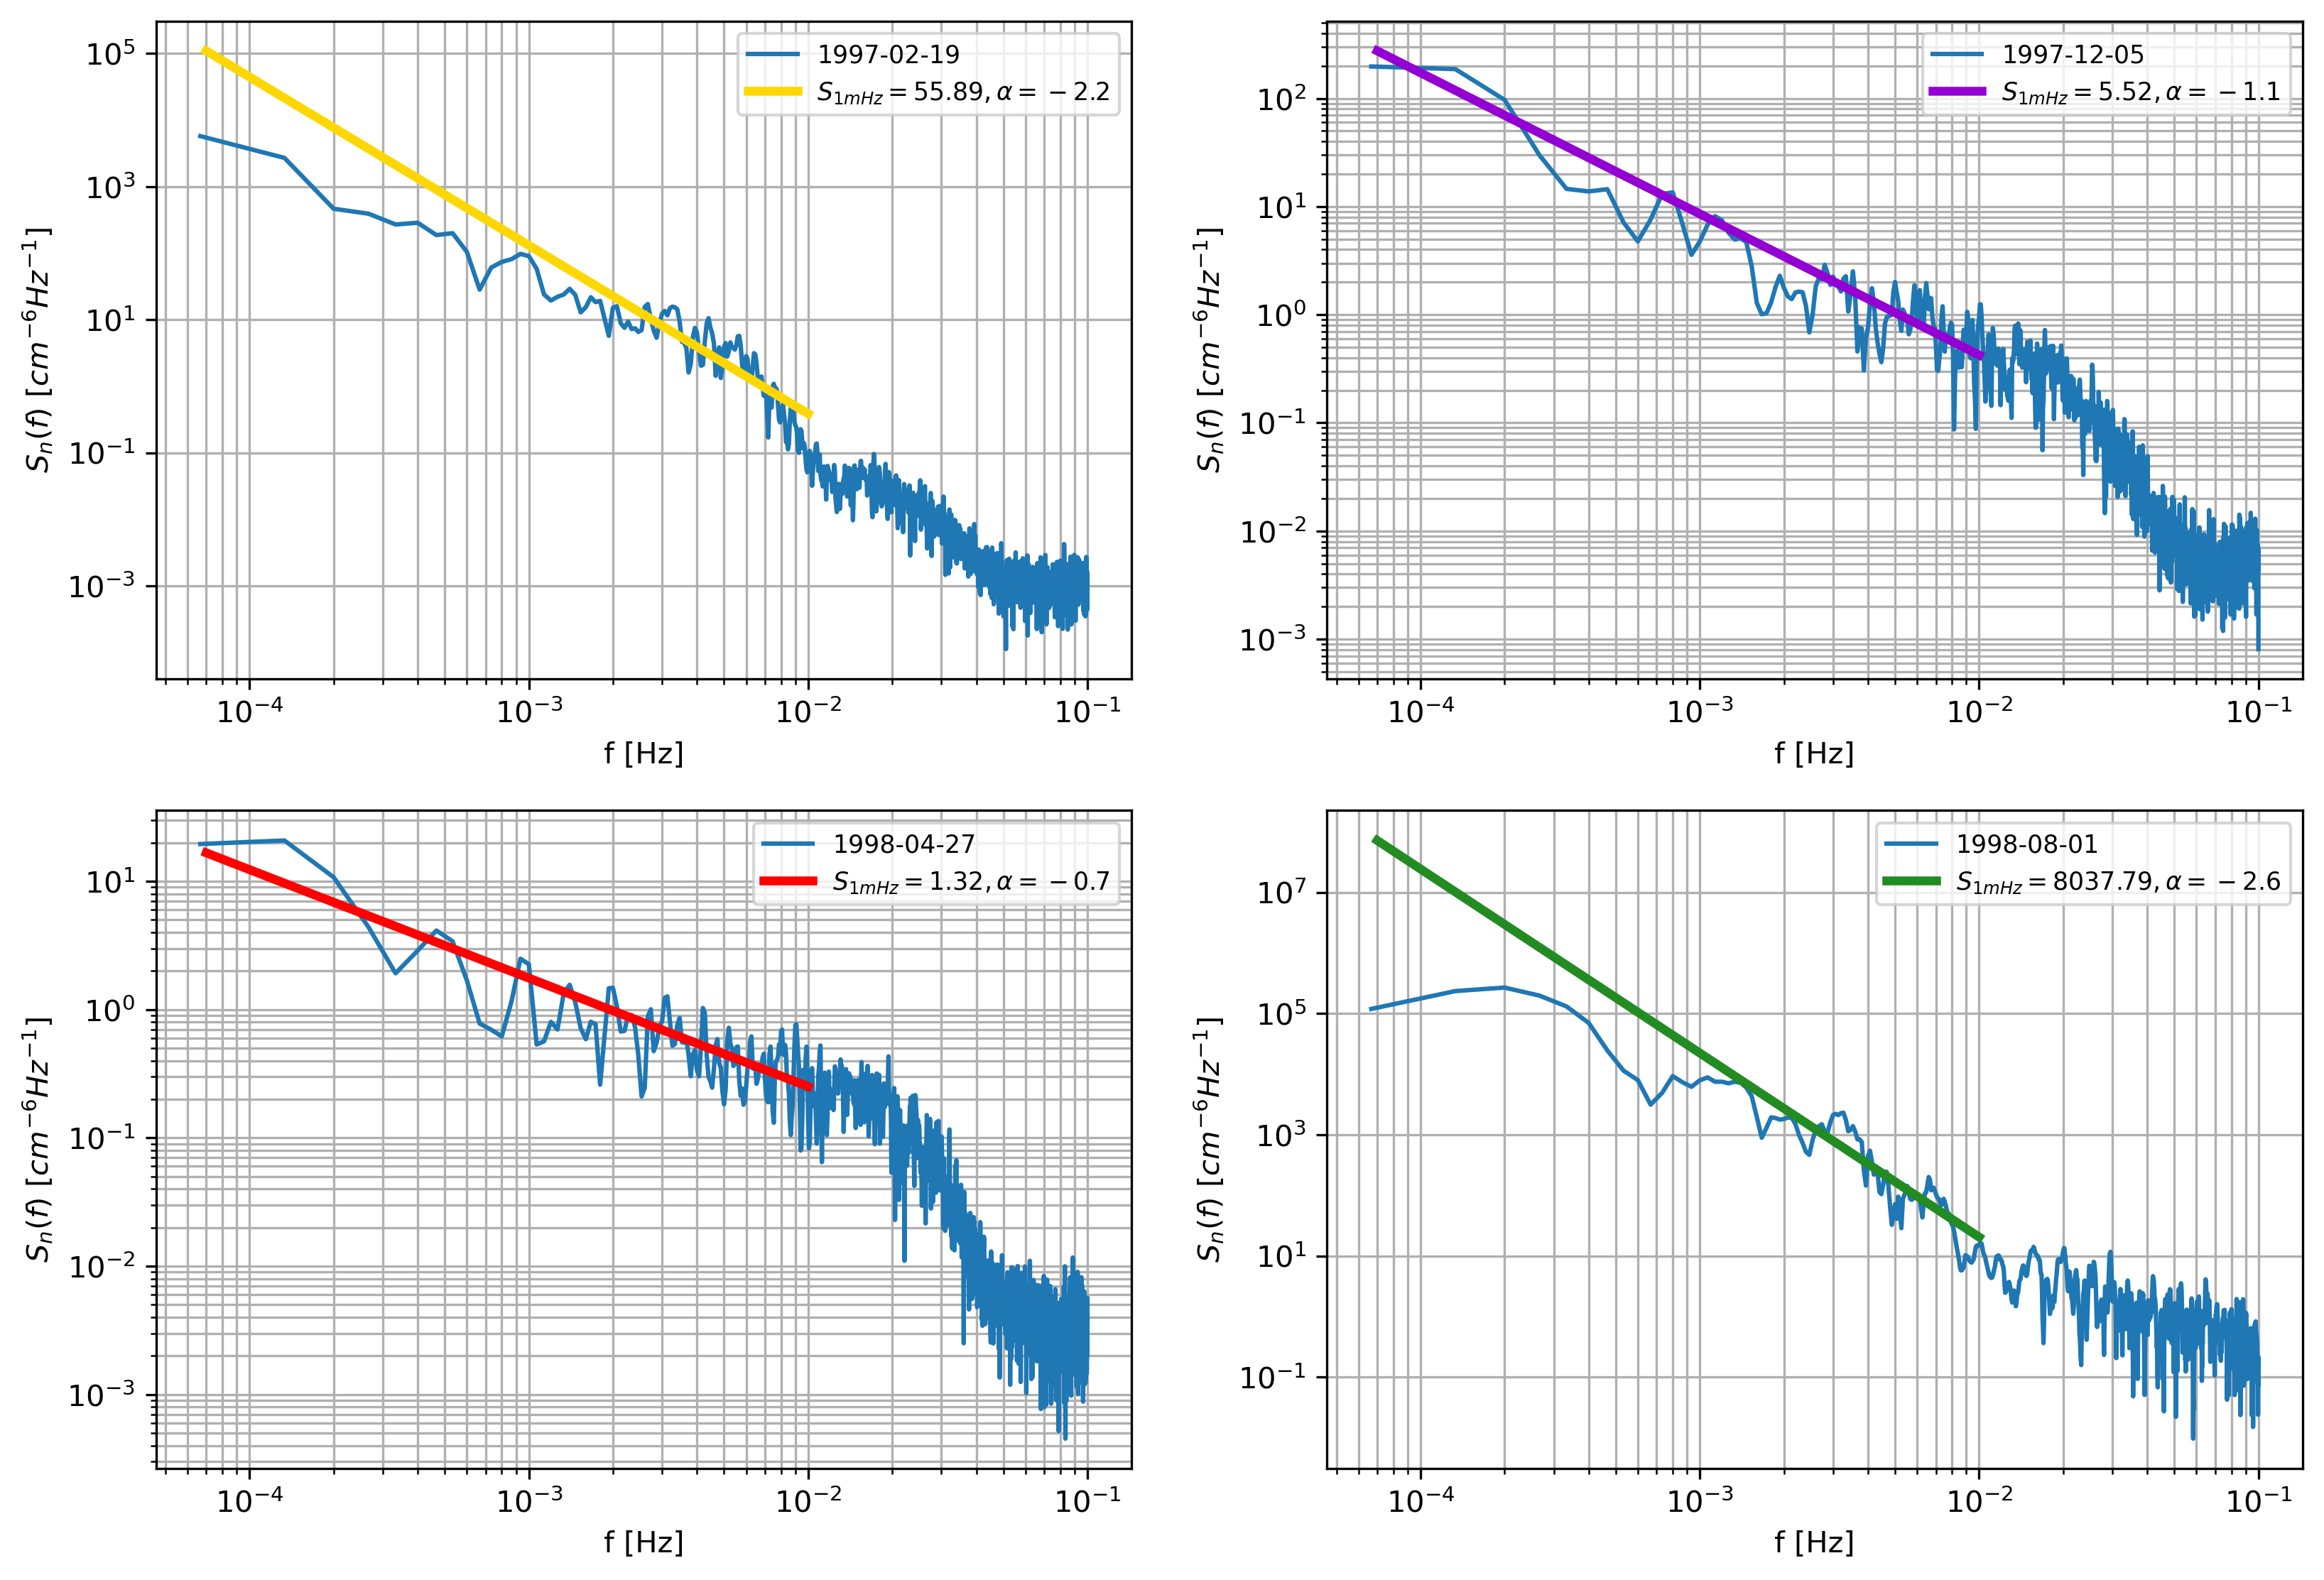

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13, 9),dpi=300)
ax = axes.flatten()
colors = ['gold','darkviolet','red','forestgreen']
indices = [inda[int(len(inda)/2)],inda[indt[int(len(inda)/2)]],inda[0],inda[-1]]
for i, index in enumerate(indices):
    xx = sne[index][0][1:]
    yy = sne[index][1][1:]
    t = powerlaws.PowerLaw1D(amplitude = amplitudes[index], x_0 = 1e-3, alpha = -alphas[index])
    ax[i].plot(xx, yy, label=dtlist[index].strftime('%Y-%m-%d'))
    ax[i].plot(np.logspace(np.log10(7e-5),-2,100), t(np.logspace(np.log10(3e-5),-2,100)), color= colors[i], lw=3,label=r"$S_{1mHz}=%3.2f, \alpha=%2.1f$" % (amplitudes[index],alphas[index]))
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlabel('f [Hz]')
    ax[i].set_ylabel(r'$S_n(f)$ [$cm^{-6}Hz^{-1}$]')
    ax[i].grid(which='both')
    ax[i].legend(loc='upper right', fontsize='small')
fig.savefig('LISA_wind_example_spectra.png')

#### Fits as a function of time

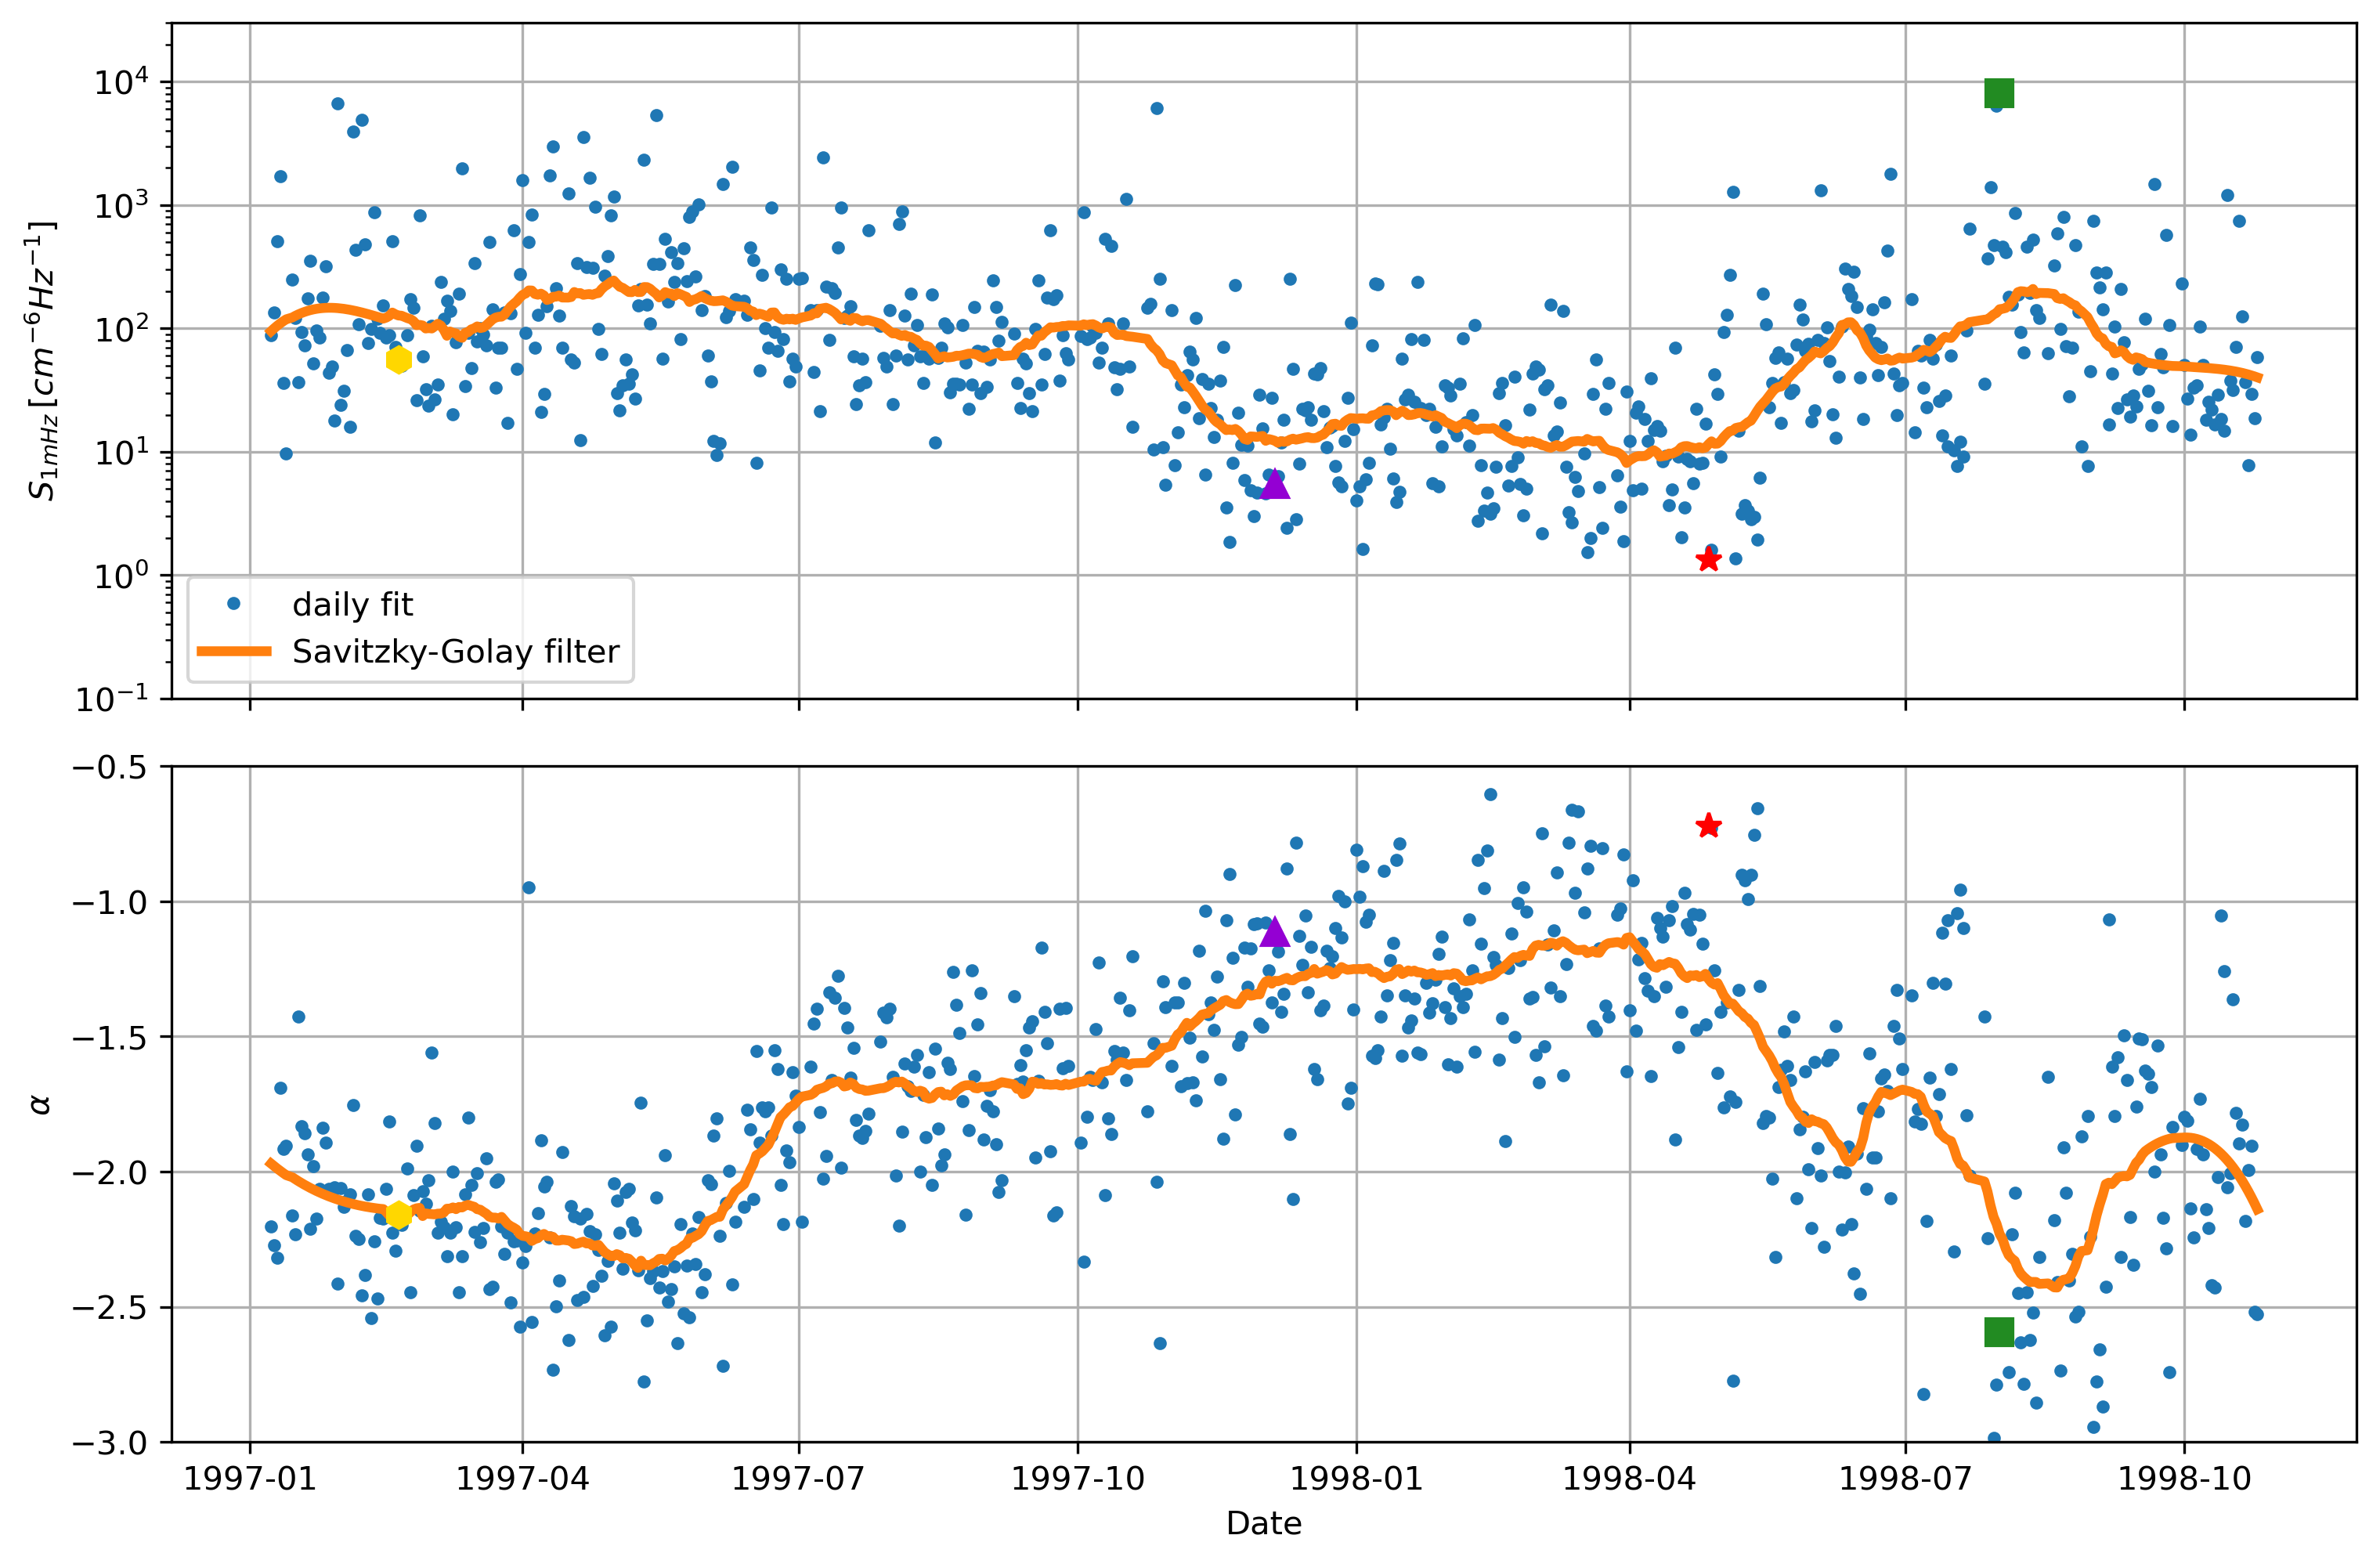

In [11]:
yl = [1e-1,3e4]
fig = plt.figure(dpi=300)
fig.set_figheight(8)
fig.set_figwidth(12)

spec = gridspec.GridSpec(ncols=1, nrows=2, 
                         width_ratios=[1], wspace=0.05, 
                         hspace=0.1, height_ratios=[1, 1]) 

ax0 = fig.add_subplot(spec[0]) 
ax0.plot_date(dtlist_t,amp_sort_t,label='daily fit', markersize=3)
# Smooth data with Savgol filter
ax0.plot(dtlist_t,10**savgol_filter(np.log10(amp_sort_t), 71, 3), lw=3,label = 'Savitzky-Golay filter')
# Add special points
ax0.plot_date(dtlist_a[int(len(inda)/2)],amp_sort_a[int(len(inda)/2)],fmt='',marker='h',markersize=8, color='gold')
ax0.plot_date(dtlist_t[int(len(inda)/2)],amp_sort_t[int(len(inda)/2)],fmt='',marker='^',markersize=8, color='darkviolet')
ax0.plot_date(dtlist_a[0],amp_sort_a[0], fmt='',marker='*',markersize=8, color='red')
ax0.plot_date(dtlist_a[-1],amp_sort_a[-1],fmt='',marker='s',markersize=8, color='forestgreen')

ax0.set_ylim(yl)
ax0.set_yscale('log')
ax0.set_ylabel(r'$S_{1mHz}\,[cm^{-6}Hz^{-1}]$')
ax0.xaxis.set_ticklabels([])
ax0.grid(True)
ax0.legend(loc='lower left')

yl = [-3,-0.5]
ax1 = fig.add_subplot(spec[1]) 
ax1.plot_date(dtlist_t,alpha_sort_t,label='daily fit', markersize=3)
# Smooth data with Savgol filter
ax1.plot(dtlist_t,savgol_filter(alpha_sort_t, 71, 3), lw=3,label = 'Sav-Gol filter')
# Add special points
ax1.plot_date(dtlist_a[int(len(inda)/2)],alpha_sort_a[int(len(inda)/2)],fmt='',marker='h',markersize=8, color='gold')
ax1.plot_date(dtlist_t[int(len(inda)/2)],alpha_sort_t[int(len(inda)/2)],fmt='',marker='^',markersize=8, color='darkviolet')
ax1.plot_date(dtlist_a[0],alpha_sort_a[0],fmt='', marker='*',markersize=8, color='red')
ax1.plot_date(dtlist_a[-1],alpha_sort_a[-1],fmt='',marker='s',markersize=8, color='forestgreen')

ax1.set_ylim(yl)
ax1.set_yscale('linear')
ax1.set_ylabel(r'$\alpha$')
ax1.set_xlabel('Date')
ax1.grid(True)

fig.savefig('LISA_wind_fit_v_time.png')

#### Statistics on daily fits

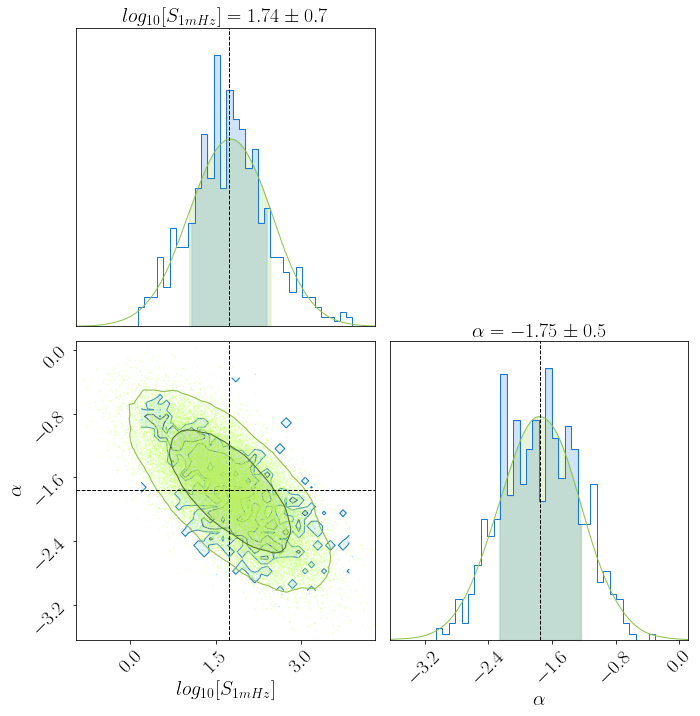

In [12]:
ch = ChainConsumer()
data = np.transpose([np.log10(amplitudes), alphas])
m = np.mean(np.transpose(data),1);
cv = np.cov(np.transpose(data))
normFit = np.random.multivariate_normal(m,cv , size=30000)

ch.add_chain(data, parameters=[r'$log_{10}[S_{1mHz}]$', r'$\alpha$'], name = 'daily fits')
ch.add_chain(normFit, parameters=[r'$log_{10}[S_{1mHz}]$', r'$\alpha$'], name = 'Guassian fit')
ch.configure(kde=[False,True] ,statistics="mean",cloud = [True,False], summary= True,shade_alpha=0.1,flip=False,smooth=0)
fig = ch.plotter.plot(figsize="column",legend=False,truth=np.mean(np.transpose(data),1))
fig.set_size_inches(5 + fig.get_size_inches())  
ax = fig.axes
ax[0].set_title(r'$log_{10}[S_{1mHz}]=%3.2f\pm%2.1f$' % (m[0],np.sqrt(cv[0,0])))
ax[3].set_title(r'$\alpha=%3.2f\pm%2.1f$' % (m[1],np.sqrt(cv[1,1])))
ax[0].title.set_fontsize(20)
ax[3].title.set_fontsize(20)
ax[2].xaxis.label.set_fontsize(20)
ax[2].yaxis.label.set_fontsize(20)
ax[3].xaxis.label.set_fontsize(20)
ax[2].tick_params(axis='x', labelsize= 20)
ax[2].tick_params(axis='y', labelsize= 20)
ax[3].tick_params(axis='x', labelsize= 20)
fig.savefig('LISA_wind_fit_stats_model.png')

## Compare with LISA sensitivity

### Single-arm case

Compute the quantity `chi` as defined in (8) of the paper and define other required constants

In [13]:
L = 2.5e9*u.m  # LISA arm length 
Beta = 1.0  # geometric factor that varies between sqrt(3)/2 and 1
lam = 1064e-9*u.m # laser wavelength 
chi = ((lam.cgs**2)*(c.e.esu)**2)/(2*np.pi*c.m_e.cgs*(c.c.cgs**2))
chi.decompose().cgs

<Quantity 5.07732752e-22 cm3>

In [14]:
# transfer function model
V = 400e3 * u.m / u.s # Velocity of solar wind
def TF1arm(f,avg_type='1arm'):
    cm2m = 0.01
    prefix = (L*chi)**2
    if avg_type =='1arm':
        tf = prefix*((25/9)*(Beta**(5/3))*(V/(2*np.pi*L*f)))
    elif avg_type == 'none':
        tf = prefix
    
    return (cm2m**2)*(tf.decompose().cgs.to_value())

In [15]:
# define LISA requirements from the Mission Requirements Document
def MRD_one_link_IFO(f):
    return 1e-11*np.sqrt((1+(2e-3/f)**4))

def MRD_one_link_ACC(f):
    return (2.4e-15*np.sqrt((1+(0.4e-3/f)**2))*np.sqrt((1+(f/8e-3)**4)))/((2*np.pi*f)**2)

def MRD_one_link_TOT(f):
    return np.sqrt(MRD_one_link_IFO(f)**2+MRD_one_link_ACC(f)**2)

In [16]:
# bin-by-bin statistics of the WIND/swe PSDs
allSpecs = np.asarray(sne)
f = np.squeeze(allSpecs[0,0,:])
sneAll = np.squeeze(allSpecs[:,1,:])

sne_mean = np.median(sneAll, axis=0)
sne_std = np.std(sneAll, axis=0)
sne_1smax = np.percentile(sneAll, 84.1, axis=0)
sne_1smin = np.percentile(sneAll, 15.9, axis=0)
sne_2smax = np.percentile(sneAll, 97.7, axis=0)
sne_2smin = np.percentile(sneAll, 2.3, axis=0)
sne_3smax = np.percentile(sneAll, 99.9, axis=0)
sne_3smin = np.percentile(sneAll, 0.1, axis=0)

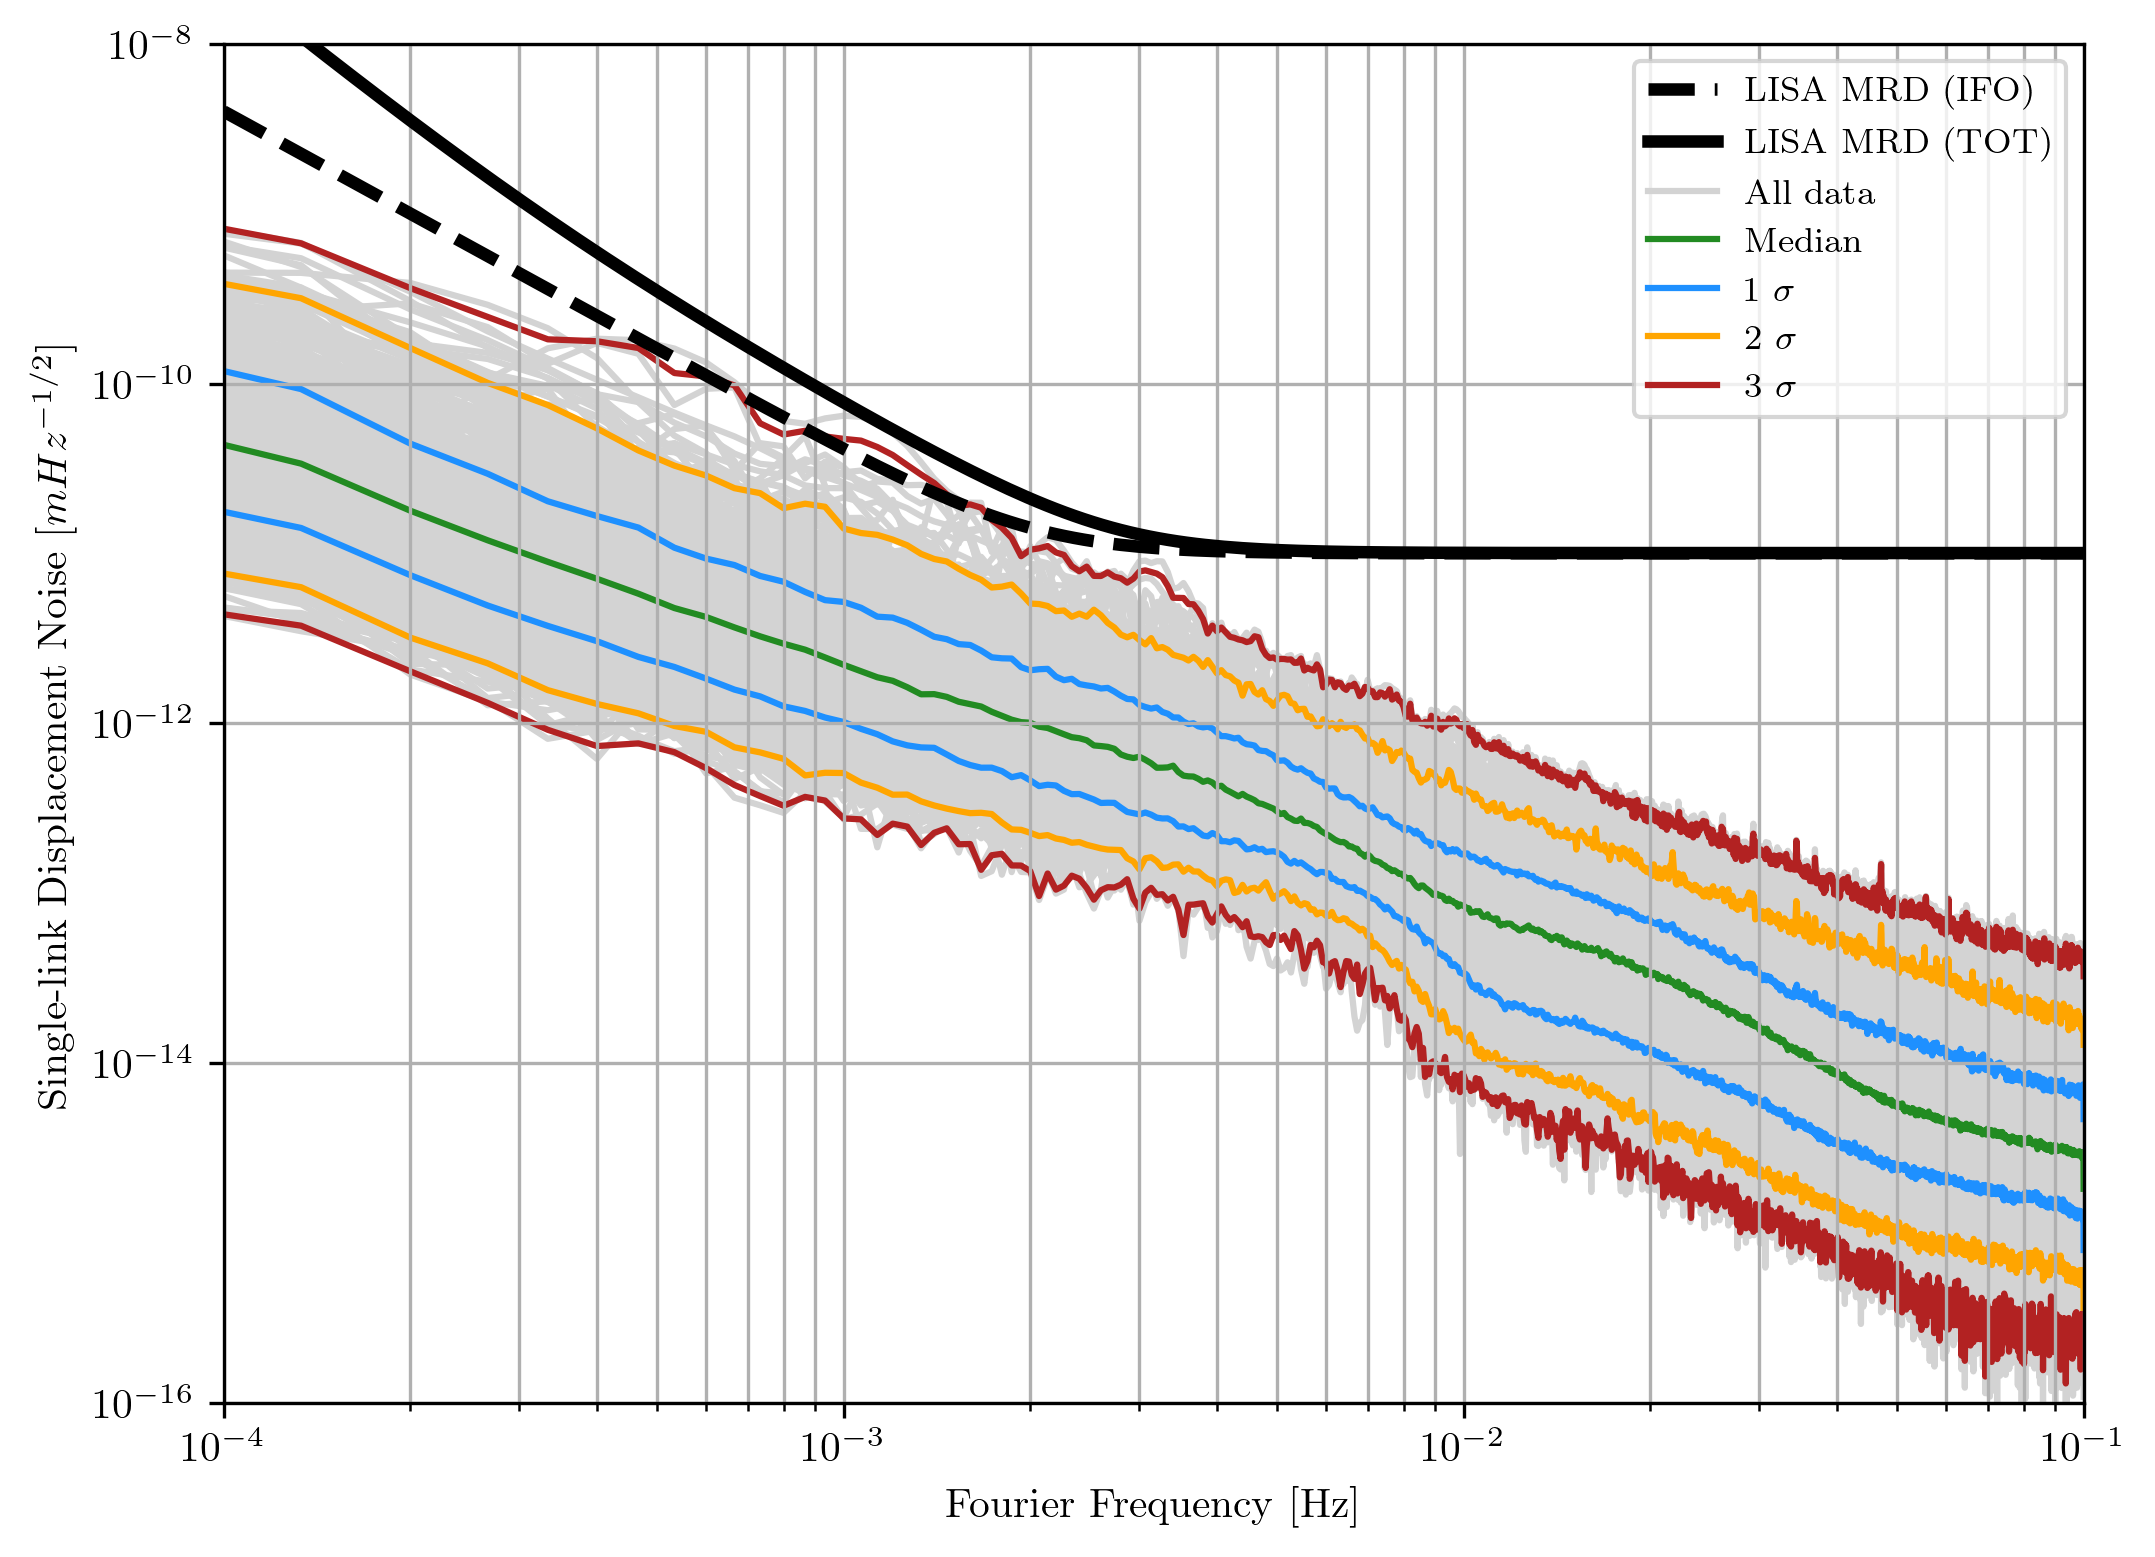

In [17]:
# plot the spectrum
tfmod = '1arm'
fig, ax = plt.subplots(nrows=1, figsize=(8, 6), dpi=300)
ff = np.logspace(-4,-1,200)
ax.plot(ff, MRD_one_link_IFO(ff), lw=3, color='black', linestyle='--',label='LISA MRD (IFO)')
ax.plot(ff, MRD_one_link_TOT(ff), lw=3, color='black', label='LISA MRD (TOT)')
cm2m = 0.01

# All the data
for i, snei in enumerate(sneAll):
    if i == 0:
        ax.plot(f[1:], np.sqrt(snei[1:]*TF1arm(f[1:],avg_type=tfmod)), color='lightgrey', zorder=0, label='All data')
    else:
        ax.plot(f[1:], np.sqrt(snei[1:]*TF1arm(f[1:],avg_type=tfmod)), color='lightgrey', zorder=0)

# Calculate mean and percentiles of all the data 
ax.plot(f[1:], np.sqrt(sne_mean[1:]*TF1arm(f[1:],avg_type=tfmod)), color='forestgreen', zorder=0, label='Median')
ax.plot(f[1:], np.sqrt(sne_1smax[1:]*TF1arm(f[1:],avg_type=tfmod)), color='dodgerblue', zorder=0, label=r'1 $\sigma$')
ax.plot(f[1:], np.sqrt(sne_1smin[1:]*TF1arm(f[1:],avg_type=tfmod)), color='dodgerblue', zorder=0)
ax.plot(f[1:], np.sqrt(sne_2smax[1:]*TF1arm(f[1:],avg_type=tfmod)), color='orange', zorder=0, label=r'2 $\sigma$')
ax.plot(f[1:], np.sqrt(sne_2smin[1:]*TF1arm(f[1:],avg_type=tfmod)), color='orange', zorder=0)
ax.plot(f[1:], np.sqrt(sne_3smax[1:]*TF1arm(f[1:],avg_type=tfmod)), color='firebrick', zorder=0, label=r'3 $\sigma$')
ax.plot(f[1:], np.sqrt(sne_3smin[1:]*TF1arm(f[1:],avg_type=tfmod)), color='firebrick', zorder=0)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Fourier Frequency [Hz]')
ax.set_ylabel('Single-link Displacement Noise [$m Hz^{-1/2}$]')
ax.set_xlim([1e-4, 1e-1])
ax.set_ylim([1e-16, 1e-8])
ax.grid(which='both')
ax.legend(loc='upper right', fontsize='small')
fig.savefig('LISA_wind_alldata.png')



#### Compare simple averaging with no averaging

The estimate from Smetana 2020 assumed electron density fluctuations that were identical along the full length of the LISA arm. Here we compare the spectra for those two cases.

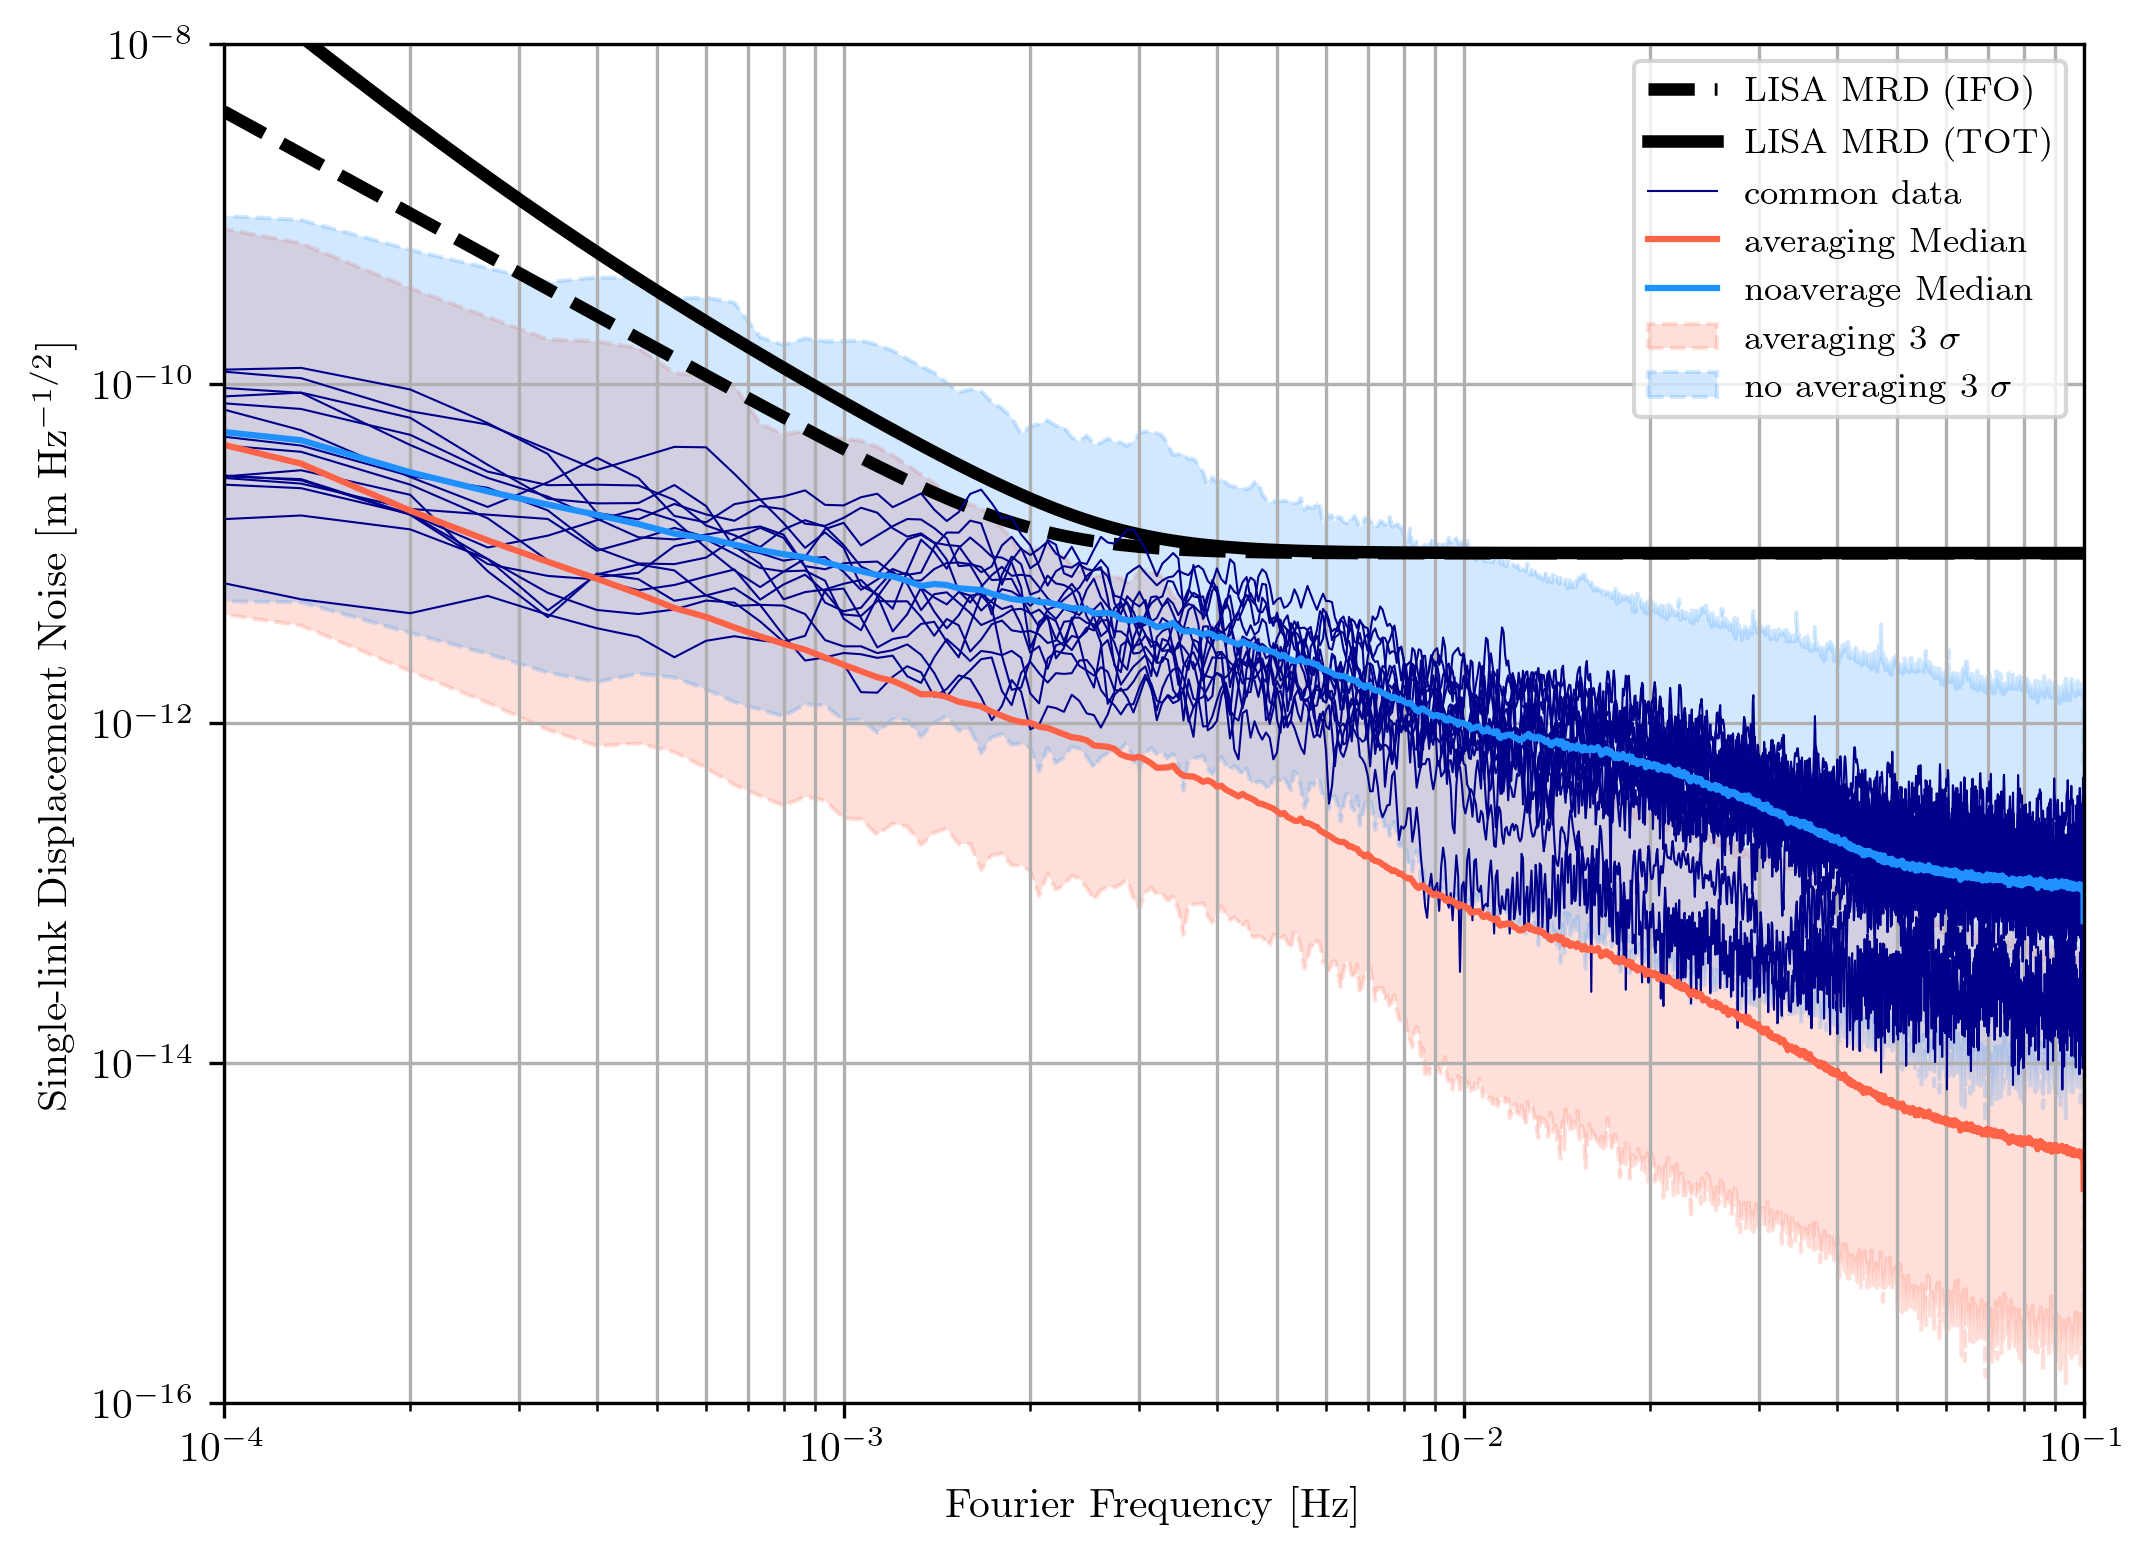

In [18]:
compDates = ['19970711','19970811','19970911','19971011','19971211','19980111','19980211','19980311','19980411','19980511','19980611','19980711','19980811','19980911','19981011']
# plot the spectrum
fig, ax = plt.subplots(nrows=1, figsize=(8, 6),dpi=300)
ff = np.logspace(-4,-1,200)
ax.plot(ff, MRD_one_link_IFO(ff), lw=3, color='black', linestyle='--',label='LISA MRD (IFO)')
ax.plot(ff, MRD_one_link_TOT(ff), lw=3, color='black', label='LISA MRD (TOT)')

# All the data
ax.fill_between(f[1:], np.sqrt(sne_3smin[1:]*TF1arm(f[1:],avg_type='1arm')),np.sqrt(sne_3smax[1:]*TF1arm(f[1:],avg_type='1arm')), color='tomato', linestyle='--', alpha=0.2, label=r'averaging 3 $\sigma$')
ax.fill_between(f[1:], np.sqrt(sne_3smin[1:]*TF1arm(f[1:],avg_type='none')),np.sqrt(sne_3smax[1:]*TF1arm(f[1:],avg_type='none')), color='dodgerblue', linestyle='--', alpha=0.2, label=r'no averaging 3 $\sigma$')
for cdi,cD in enumerate(compDates):
    sn = sne[datelist.index(cD)]
    if cdi == 0:
        ax.plot(sn[0][1:],np.sqrt(sn[1][1:]*TF1arm(sn[0][1:],avg_type='none')),color='darkblue',lw=0.5,label='common data')
    else:
        ax.plot(sn[0][1:],np.sqrt(sn[1][1:]*TF1arm(sn[0][1:],avg_type='none')),color='darkblue',lw=0.5)

ax.plot(f[1:], np.sqrt(sne_mean[1:]*TF1arm(f[1:],avg_type='1arm')), color='tomato', label='averaging Median')
ax.plot(f[1:], np.sqrt(sne_mean[1:]*TF1arm(f[1:],avg_type='none')), color='dodgerblue', label='noaverage Median')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Fourier Frequency [Hz]')
ax.set_ylabel('Single-link Displacement Noise [m Hz$^{-1/2}$]')
ax.set_xlim([1e-4, 1e-1])
ax.set_ylim([1e-16, 1e-8])
ax.grid(which='both')
ax.legend(loc='upper right', fontsize='small')
fig.savefig('LISA_wind_avg_v_no_avg.png')